In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

### Carregando Dataset do professor

In [2]:
# testando amostras do professor
df_train = pd.read_csv('dataset/har-example-mo436/train.csv')
df_test = pd.read_csv('dataset/har-example-mo436/test.csv')
df_val = pd.read_csv('dataset/har-example-mo436/validation.csv')

X_train = df_train.drop(columns=[df_train.columns[0], 'gyro-end-time', 'level_0', 'accel-end-time', 'gyro-start-time', 'index', 'user', 'serial', 'accel-start-time', 'csv', 'timestamp diff', 'activity code', 'window', 'standard activity code'])
X_test = df_test.drop(columns=[df_train.columns[0], 'gyro-end-time', 'level_0', 'accel-end-time', 'gyro-start-time', 'index', 'user', 'serial', 'accel-start-time', 'csv', 'timestamp diff', 'activity code', 'window', 'standard activity code'])
X_val = df_val.drop(columns=[df_train.columns[0], 'gyro-end-time', 'level_0', 'accel-end-time', 'gyro-start-time', 'index', 'user', 'serial', 'accel-start-time', 'csv', 'timestamp diff', 'activity code', 'window', 'standard activity code'])

y_train = df_train.pop('standard activity code')
y_test = df_test.pop('standard activity code')
y_val = df_val.pop('standard activity code')

print("shape train: ", X_train.shape)
print("shape test: ", X_test.shape)
print("shape valid: ", X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

shape train:  (60, 360)
shape test:  (24, 360)
shape valid:  (24, 360)
(60,) (24,) (24,)


### Dataset e Dataloader

In [3]:
class CSVLabeledDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.transform = transform

        self.features = X
        self.labels = y

        if self.transform:
            self.features = self.transform(self.features)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        sample = torch.tensor(self.features[idx], dtype=torch.float32)#.unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sample, label

In [4]:
class Jitter:
    def __init__(self, sigma=0.01):
        self.sigma = sigma

    def __call__(self, x):
        noise = np.random.normal(loc=0, scale=self.sigma, size=x.shape)
        return x + noise

class Scaling:
    def __init__(self, sigma=0.1):
        self.sigma = sigma

    def __call__(self, x):
        factor = np.random.normal(loc=1.0, scale=self.sigma)
        return x * factor

class TimeShift:
    def __init__(self, max_shift=50):
        self.max_shift = max_shift

    def __call__(self, x):
        shift = np.random.randint(-self.max_shift, self.max_shift)
        return np.roll(x, shift)

# classe de transformacoes nos dados
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x):
        for t in self.transforms:
            if callable(t):
                x = t(x)
            else:
                x = t.fit_transform(x)
        return x

In [5]:
def createDataLoader(X_train, X_test, X_val, y_train, y_test, y_val, batch_size=32):
    # scaler = StandardScaler()
    train_transform = Compose([
        StandardScaler(),
        # Jitter(),
        # Scaling(),
        # TimeShift()
    ])
    valid_test_transform = Compose([
        StandardScaler()
    ])

    train_dataset = CSVLabeledDataset(X_train, y_train, transform=train_transform)
    test_dataset = CSVLabeledDataset(X_test, y_test, transform=valid_test_transform)
    val_dataset = CSVLabeledDataset(X_val, y_val, transform=valid_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataset, test_dataset, val_dataset, train_loader, test_loader, val_loader

In [6]:
train_dataset, test_dataset, val_dataset, train_loader, test_loader, val_loader = createDataLoader(X_train.values, X_test.values, X_val.values, y_train.values, y_test.values, y_val.values)

In [7]:
for batch_idx, (x, y) in enumerate(train_loader):
    print(x.shape, y.shape)
    break

torch.Size([32, 360]) torch.Size([32])


In [8]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 6)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [9]:
input_dim = train_dataset.features.shape[1]
model = Net(input_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(input_dim, model)

360 Net(
  (fc1): Linear(in_features=360, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
)


In [10]:
def trainModel(model, train_loader, criterion, optimizer):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for batch_idx, (x, y) in enumerate(train_loader):
    optimizer.zero_grad()
    logits = model(x)
    loss = criterion(logits, y)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = logits.max(1)
    total += y.size(0)
    correct += predicted.eq(y).sum().item()

  epoch_loss = running_loss / len(train_loader)
  epoch_acc = 100. * correct / total
  return epoch_loss, epoch_acc

def evalModel(model, val_loader, criterion):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for batch_idx, (x, y) in enumerate(val_loader):
      logits = model(x)
      loss = criterion(logits, y)

      running_loss += loss.item()
      _, predicted = logits.max(1)
      total += y.size(0)
      correct += predicted.eq(y).sum().item()

  epoch_loss = running_loss / len(val_loader)
  epoch_acc = 100. * correct / total
  return epoch_loss, epoch_acc

In [11]:
num_epochs = 100

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = trainModel(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evalModel(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}')

Epoch 1/100, Train Loss: 1.8306, Train Acc: 10.00, Val Loss: 1.7946, Val Acc: 16.67
Epoch 2/100, Train Loss: 1.6593, Train Acc: 33.33, Val Loss: 1.7914, Val Acc: 16.67
Epoch 3/100, Train Loss: 1.5363, Train Acc: 45.00, Val Loss: 1.7902, Val Acc: 25.00
Epoch 4/100, Train Loss: 1.4329, Train Acc: 61.67, Val Loss: 1.7913, Val Acc: 20.83
Epoch 5/100, Train Loss: 1.3418, Train Acc: 75.00, Val Loss: 1.7917, Val Acc: 20.83
Epoch 6/100, Train Loss: 1.2642, Train Acc: 76.67, Val Loss: 1.7936, Val Acc: 20.83
Epoch 7/100, Train Loss: 1.2106, Train Acc: 76.67, Val Loss: 1.7962, Val Acc: 16.67
Epoch 8/100, Train Loss: 1.1599, Train Acc: 81.67, Val Loss: 1.7998, Val Acc: 16.67
Epoch 9/100, Train Loss: 1.0937, Train Acc: 75.00, Val Loss: 1.8048, Val Acc: 20.83
Epoch 10/100, Train Loss: 1.0347, Train Acc: 81.67, Val Loss: 1.8109, Val Acc: 20.83
Epoch 11/100, Train Loss: 0.9880, Train Acc: 73.33, Val Loss: 1.8189, Val Acc: 20.83
Epoch 12/100, Train Loss: 0.9288, Train Acc: 78.33, Val Loss: 1.8283, Val 

In [12]:
# avaliando modelo sem augmentation
test_loss, test_acc = evalModel(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}')

Test Loss: 1.7272, Test Acc: 37.50


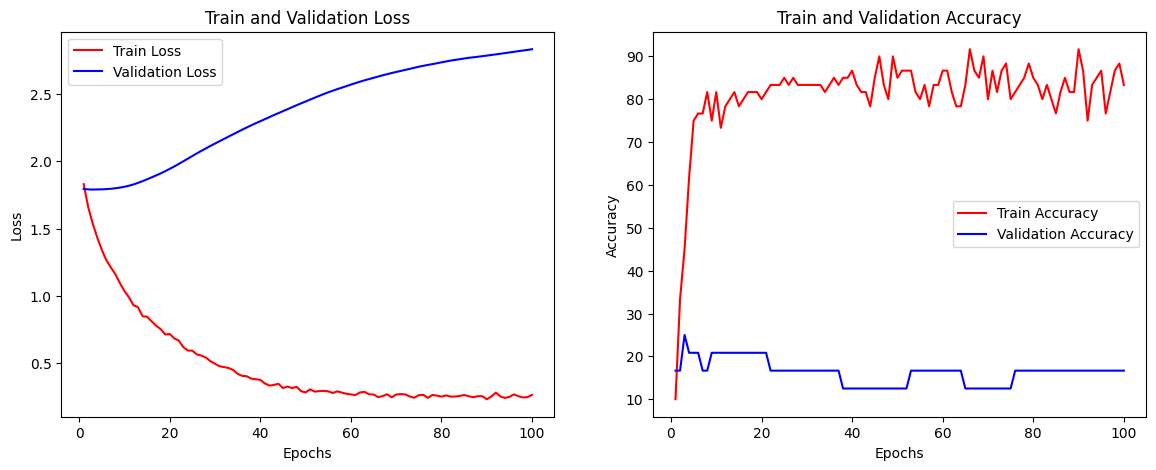

In [13]:
# Plotando a perda e a precisão do modelo sem augmentation
epochs = range(1, num_epochs + 1) # é 36 epocas porque com early stopping so rodou 36 epocas

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r', label='Train Loss')
plt.plot(epochs, val_losses, 'b', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'b', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

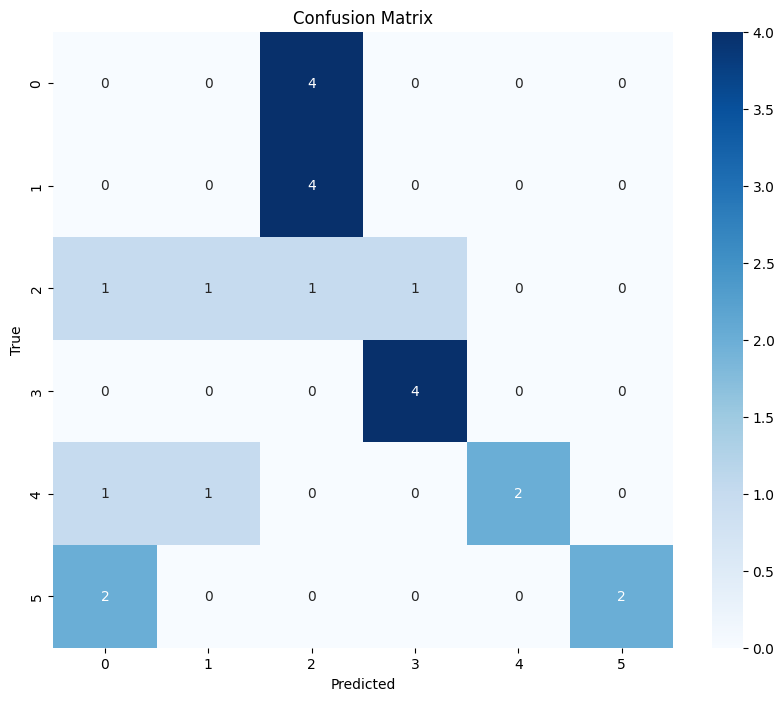

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         4
           2       0.11      0.25      0.15         4
           3       0.80      1.00      0.89         4
           4       1.00      0.50      0.67         4
           5       1.00      0.50      0.67         4

    accuracy                           0.38        24
   macro avg       0.49      0.38      0.40        24
weighted avg       0.49      0.38      0.40        24



In [14]:
# Obter previsões do conjunto de teste
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(test_loader):
        outputs = model(x)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Calcular a matriz de confusão
cm = confusion_matrix(all_labels, all_preds)

# Visualizar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Relatório de classificação
print(classification_report(all_labels, all_preds))

### Testando Random Forest

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [16]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("\nAvaliação do modelo:")
print(f"Acurácia: {accuracy * 100:.2f}%")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))


Avaliação do modelo:
Acurácia: 66.67%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         4
           1       0.00      0.00      0.00         4
           2       0.60      0.75      0.67         4
           3       0.75      0.75      0.75         4
           4       1.00      0.75      0.86         4
           5       0.75      0.75      0.75         4

    accuracy                           0.67        24
   macro avg       0.60      0.67      0.62        24
weighted avg       0.60      0.67      0.62        24


Matriz de Confusão:
[[4 0 0 0 0 0]
 [4 0 0 0 0 0]
 [0 0 3 1 0 0]
 [0 0 0 3 0 1]
 [0 0 1 0 3 0]
 [0 0 1 0 0 3]]


/Users/filipealvessampaio/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filipealvessampaio/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filipealvessampaio/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,